<a href="https://colab.research.google.com/github/davideneffat/movie_recommendations/blob/main/movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import torch
from torch import Tensor
print(torch.__version__)

2.1.0+cu121


In [14]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.1.0+cu121.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-jletjf89
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-jletjf89
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit fba03d4be9292faaee30c2659ace14bb431ca3fc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [15]:
from torch_geometric.data import download_url, extract_zip

#if running on colab
url = 'https://files.grouplens.org/datasets/movielens/ml-20m.zip'
extract_zip(download_url(url, '.'), '.')

movies_path = './ml-20m/movies.csv'
ratings_path = './ml-20m/ratings.csv'

Using existing file ml-20m.zip
Extracting ./ml-20m.zip


In [ ]:
#if running locally
import os
import requests
import zipfile

def download_url(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def extract_zip(zip_file_path, extract_folder):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

url = 'https://files.grouplens.org/datasets/movielens/ml-20m.zip'
zip_file_name = 'ml-20m.zip'
download_folder = 'C:/Users/david/Downloads/'  # download location
extract_folder = 'C:/Users/david/Downloads/'   # extraction location

zip_file_path = os.path.join(download_folder, zip_file_name)
download_url(url, zip_file_path)

extract_zip(zip_file_path, extract_folder)

movies_path = os.path.join(extract_folder, 'ml-20m', 'movies.csv')
ratings_path = os.path.join(extract_folder, 'ml-20m', 'ratings.csv')

In [16]:
import pandas as pd

print('movies.csv:')
pd.read_csv(movies_path).head()

movies.csv:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [17]:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')#creates a binary indicator for each genre, separated by the '|' delimiter
print(genres[["Action", "Adventure", "Drama", "Horror","Animation","Fantasy"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)#tensor of movie features, size (9742, 20) = (# nodes, # genres)

         Action  Adventure  Drama  Horror  Animation  Fantasy
movieId                                                      
1             0          1      0       0          1        1
2             0          1      0       0          0        1
3             0          0      0       0          0        0
4             0          0      1       0          0        0
5             0          0      0       0          0        0


In [18]:
movies_df.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [19]:
ratings_df = pd.read_csv(ratings_path)

In [20]:
print('ratings.csv:')
ratings_df.head()

ratings.csv:


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


<ipython-input-21-ad68d10fd129>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


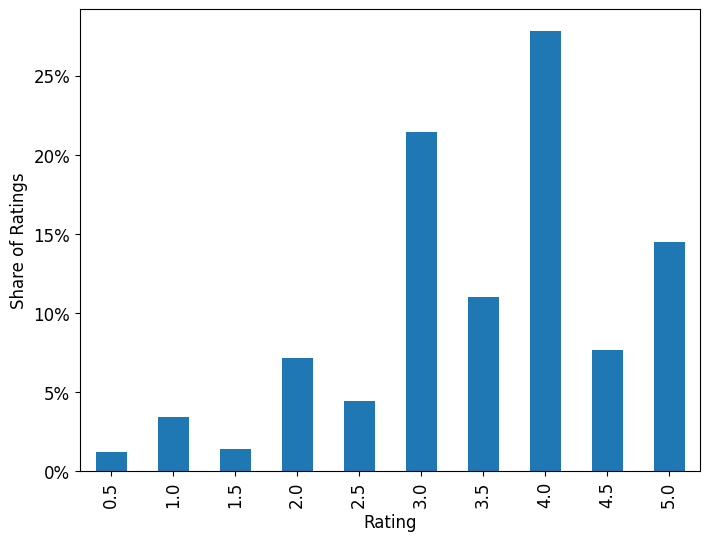

In [21]:
#print ratings distribution
from matplotlib import pyplot as plt

fig = plt.figure()
ax = ratings_df.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [22]:
#let's round ratings to integers for simplicity
import numpy as np

ratings_df['rating'] = np.ceil(ratings_df['rating']).astype(int)

<ipython-input-23-d6e9c3372f83>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


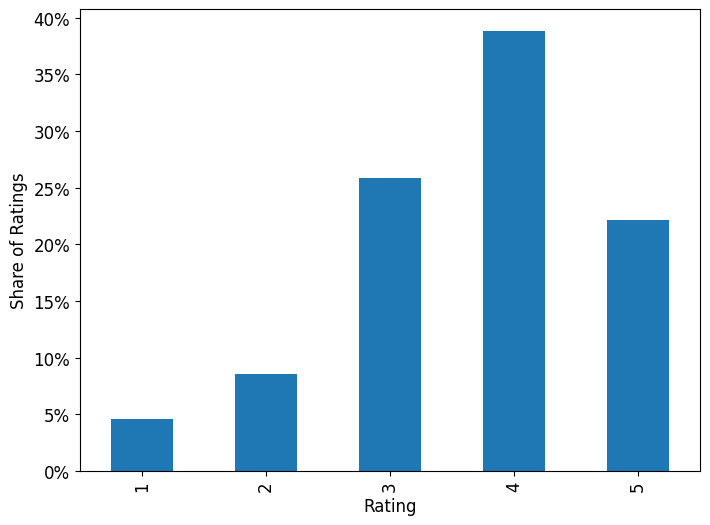

In [23]:
#print new ratings distribution
from matplotlib import pyplot as plt

fig = plt.figure()
ax = ratings_df.rating.value_counts(True).sort_index().plot.bar(figsize=(8,6))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Share of Ratings', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig.savefig('Ratings_distribution.png')

In [24]:
#to take into account review rating: duplicate each row (so each edge) for a value equal to the rating
ratings_df = ratings_df.loc[ratings_df.index.repeat(ratings_df['rating'])].reset_index(drop=True)
ratings_df.head(15)

,userId,movieId,rating,timestamp
0,1,2,4,1112486027
1,1,2,4,1112486027
2,1,2,4,1112486027
3,1,2,4,1112486027
4,1,29,4,1112484676
5,1,29,4,1112484676
6,1,29,4,1112484676
7,1,29,4,1112484676
8,1,32,4,1112484819
9,1,32,4,1112484819


In [25]:
# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),#because userId are not consecutive values, there are jumps. Same for movies
})
print("Mapping of user IDs to consecutive values:")
print(unique_user_id.head())
print(unique_user_id.tail())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print(unique_movie_id.head())
print(unique_movie_id.tail())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id, left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)#create tensor of user ids
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id, left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)#create tensor of movies ids

#create tensor of edges (userId -> movieId)
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)#joint the 2 id tensors into a single tensor of size (2, #edges)

print()
print("Final edge indices pointing from users to movies:")
print(edge_index_user_to_movie)

Mapping of user IDs to consecutive values:
   userId  mappedID
0       1         0
1       2         1
2       3         2
3       4         3
4       5         4
        userId  mappedID
138488  138489    138488
138489  138490    138489
138490  138491    138490
138491  138492    138491
138492  138493    138492

Mapping of movie IDs to consecutive values:
   movieId  mappedID
0        1         0
1        2         1
2        3         2
3        4         3
4        5         4
       movieId  mappedID
27273   131254     27273
27274   131256     27274
27275   131258     27275
27276   131260     27276
27277   131262     27277

Final edge indices pointing from users to movies:
tensor([[     0,      0,      0,  ..., 138492, 138492, 138492],
        [     1,      1,      1,  ...,  14293,  14293,  14293]])


In [26]:
#define functions to get original movie id from the mapped one and viceversa
def get_original_node(index):
  row = unique_movie_id[unique_movie_id['mappedID'] == index]
  return row['movieId'].values[0]

def get_mapped_node(index):
  row = unique_movie_id[unique_movie_id['movieId'] == index]
  return row['mappedID'].values[0]

print(get_original_node(6405))
print(get_mapped_node(1258))

6515
1230


In [27]:
#let's create the graph
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()

# Save node indices:
data["user"].node_id = torch.arange(len(unique_user_id))
data["movie"].node_id = torch.arange(len(movies_df))

# Add the node features and edge indices:
data["movie"].x = movie_feat
data["user", "rates", "movie"].edge_index = edge_index_user_to_movie  #edge_index = tensor (2,#edges) with for each edge (mapped) user id and (mapped) movie id

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)

print(data)


HeteroData(
  user={ node_id=[138493] },
  movie={
    node_id=[27278],
    x=[27278, 20],
  },
  (user, rates, movie)={ edge_index=[2, 73079876] },
  (movie, rev_rates, user)={ edge_index=[2, 73079876] }
)


In [ ]:
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing, and 30% of edges for supervision.
transform = T.RandomLinkSplit(
    num_val=0.1,#10% validation set
    num_test=0.1,#10% test set
    disjoint_train_ratio=0.3,#30% disjoint training set
    neg_sampling_ratio=2.0,#negative samples are double of positive samples
    add_negative_train_samples=False,
    edge_types=("user", "rates", "movie"),
    rev_edge_types=("movie", "rev_rates", "user"),
)

# edge_index (edges used for message passing) + edge_label_index (edges used for supervision) = training_set = 80%

train_data, val_data, test_data = transform(data)
print("Training data:")
print("--------------")
print(train_data)
print()
print("User IDs:")
print(train_data["user", "rates", "movie"].edge_index[0][:10])
print("Movie IDs:")
print(train_data["user", "rates", "movie"].edge_index[1][:10])
print("Edges labels:")
print(train_data["user", "rates", "movie"].edge_label[:10])
print(train_data["user", "rates", "movie"].edge_label[-10:]) #only positive labels (1)
print("Edges labels indices:")
print(train_data["user", "rates", "movie"].edge_label_index[0][:10])
print(train_data["user", "rates", "movie"].edge_label_index[1][:10])

print()
print("Validation data:")
print("-----------------")
print(val_data)
print()
print("Test data:")
print("-----------")
print(test_data)

In [ ]:
#creation of mini batches
from torch_geometric.loader import LinkNeighborLoader

#The data loader will add the following attributes to the returned mini-batch:
#-n_id The global node index for every sampled node
#-e_id The global edge index for every sampled edge
#-input_id: The global index of the edge_label_index
#-num_sampled_nodes: The number of sampled nodes in each hop
#-num_sampled_edges: The number of sampled edges in each hop

# Define seed edges:
edge_label_index = train_data["user", "rates", "movie"].edge_label_index  #Size([2, 24201])
edge_label = train_data["user", "rates", "movie"].edge_label  #Size([24201])

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],#The number of neighbors to sample for each node in each iteration (20 the first, 10 the second)
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,#The labels of edge indices for which neighbors are sampled
    batch_size=128,
    shuffle=True,
)

# Inspect a sample:
sampled_data = next(iter(train_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

assert sampled_data["user", "rates", "movie"].edge_label_index.size(1) == 3 * 128
assert sampled_data["user", "rates", "movie"].edge_label.min() == 0
assert sampled_data["user", "rates", "movie"].edge_label.max() == 1

In [ ]:
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn.functional as F

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Our final classifier applies the dot-product between source and destination
# node embeddings to derive edge-level predictions: (Combines user and movie node embeddings to create edge-level representations)
class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_movie: Tensor, edge_label_index: Tensor) -> Tensor:
        # Convert node embeddings to edge-level representations:
        edge_feat_user = x_user[edge_label_index[0]]
        edge_feat_movie = x_movie[edge_label_index[1]]

        # Apply dot-product to get a prediction per supervision edge:
        return (edge_feat_user * edge_feat_movie).sum(dim=-1)


class Model(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Since the dataset does not come with rich features, we also learn two
        # embedding matrices for users and movies:
        self.movie_lin = torch.nn.Linear(20, hidden_channels)  #(movie_lin): Linear(in_features=20, out_features=64, bias=True)
        self.user_emb = torch.nn.Embedding(data["user"].num_nodes, hidden_channels)#learn node embedding for users
        self.movie_emb = torch.nn.Embedding(data["movie"].num_nodes, hidden_channels)#learn node embedding for movies

        # Instantiate homogeneous GNN:
        self.gnn = GNN(hidden_channels)

        # Convert GNN model into a heterogeneous variant (we have user and movie types nodes):
        self.gnn = to_hetero(self.gnn, metadata=data.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),#just learned embeddings
          "movie": self.movie_lin(data["movie"].x) + self.movie_emb(data["movie"].node_id),#movie genres + learned embeddings
        }

        # `x_dict` holds feature matrices of all node types
        # `edge_index_dict` holds all edge indices of all edge types
        x_dict = self.gnn(x_dict, data.edge_index_dict)
        pred = self.classifier(
            x_dict["user"],
            x_dict["movie"],
            data["user", "rates", "movie"].edge_label_index,
        )

        return pred


model = Model(hidden_channels=64)

print(model)

In [ ]:
#train model
import tqdm
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: '{device}'")

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1, 6):#reduce to 6 for 10/20m dataset, 11 for small
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):#iterating over mini-batches
        optimizer.zero_grad()

        sampled_data.to(device)
        pred = model(sampled_data)

        ground_truth = sampled_data["user", "rates", "movie"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

In [ ]:
# Define the validation seed edges:
edge_label_index = val_data["user", "rates", "movie"].edge_label_index
edge_label = val_data["user", "rates", "movie"].edge_label

val_loader = LinkNeighborLoader(#creates mini-batches for validation set
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 128,
    shuffle=False,
)

sampled_data = next(iter(val_loader))

print("Sampled mini-batch:")
print("===================")
print(sampled_data)

In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))
        ground_truths.append(sampled_data["user", "rates", "movie"].edge_label)

pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")
print()
print("Predictions for existing edges:")
print(pred[:30])
print(ground_truth[:30])
print("Predictions for non-existing edges:")
print(pred[-30:])
print(ground_truth[-30:])

In [ ]:
#test our model prediction for a specific user:
user_index = 599  #value from 1 to 610 for the 100k nodes dataset

In [ ]:
user_index = user_index - 1  #due to the mapping (mapped used ids start from 0)
user_ids = torch.full((data["movie"].num_nodes,), user_index)
movie_ids = torch.tensor(unique_movie_id['mappedID'])
edge_label_index = torch.stack([user_ids, movie_ids], dim=0)#joint the 2 id tensors into a single tensor of size (2, #edges)

print(edge_label_index)  #tensor with all possible movies that our user can see

val_loader = LinkNeighborLoader(#creates mini-batches for validation set
    data=data,
    num_neighbors=[20, 10],
    edge_label_index=(("user", "rates", "movie"), edge_label_index),
    batch_size=3 * 128,
    shuffle=False,
)

preds = []
for sampled_data in tqdm.tqdm(val_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data))

pred = torch.cat(preds, dim=0).cpu().numpy()

print()

In [ ]:
def get_max(): #function that extract max probability from probabilities array
  max = pred[0]
  #maxIndex = 0
  for i in range(len(pred)):
      if pred[i] > max:
          max = pred[i]
          maxIndex = i
  print(get_original_node(maxIndex))#already seen movies, the last is the not-seen one
  return maxIndex

In [ ]:
user_index = user_index + 1  #reverse mapping

In [ ]:
#let's find the first most similar movie not already seen
most_similar_movie = get_max()
row = ratings_df[(ratings_df['userId'] == user_index) & (ratings_df['movieId'] == get_original_node(most_similar_movie))]
while not row.empty: #repeat untill find a not-seen movie
  pred[most_similar_movie] = -100
  most_similar_movie = get_max()
  row = ratings_df[(ratings_df['userId'] == user_index) & (ratings_df['movieId'] == get_original_node(most_similar_movie))]
print("Most similar not-seen movie for user {} is {}".format(user_index, get_original_node(most_similar_movie)))

In [ ]:
#let's show the movies that our user has seen
print("Movies already seen by user {}:".format(user_index))
result_df = ratings_df[ratings_df['userId'] == user_index].merge(movies_df, on='movieId', how='inner')
unique_movies = result_df.drop_duplicates(subset=['movieId'])
unique_movies[['rating','title','genres']]

In [ ]:
#let's show user's favourite genres to compare with our prediction
high_rated_movies = unique_movies[unique_movies['rating'].isin([4, 5])]#only the ones reviewed at list 4 by our user

genres = high_rated_movies['genres'].str.get_dummies('|')
# Calculate the number of occurrences of each genre
genre_counts = genres.sum()
# Sort genres by their occurrence in descending order
sorted_genres = genre_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_genres.plot(kind='bar', color='skyblue')
plt.title('Top Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
#let's print our prediction
print("Recommended movie for user {}:".format(user_index))
print("'{}'".format(movies_df[movies_df.index == get_original_node(most_similar_movie)]['title'].values[0]))
print("It's genres are:")
print(movies_df[movies_df.index == get_original_node(most_similar_movie)]['genres'].values)

In [ ]:
movies_df.head(-20)

In [ ]:
ratings_df.head(-10)